# Adaptive and Gradient Boosting

In this notebook, we demonstrate the use of AdaBoost and gradient boosting, incuding several state-of-the-art implementations of this very powerful and flexible algorithm that greatly speed up training. 

We use the stock return dataset with a few engineered factors created in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature_engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb).

## Imports and Settings

In [1]:
%matplotlib inline

import warnings
import os
from datetime import datetime
from pathlib import Path
import quandl
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import graphviz

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, precision_recall_curve

In [2]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir(exist_ok=True)

In [3]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

## Prepare Data

### Get source

We use the `engineered_features` dataset created in [Chapter 4, Alpha Factor Research](../04_alpha_factor_research)

Set data store location:

In [4]:
DATA_STORE = '../data/assets.h5'

In [12]:
def get_data(start='2000', end='2018', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = f'target_{holding_period}m'
    with pd.HDFStore(DATA_STORE) as store:
        df = store['engineered_features']

    if start is not None and end is not None:
        df = df.loc[idx[:, start: end], :]
    if dropna:
        df = df.dropna()
        
    y = (df[target]>0).astype(int)
    X = df.drop([c for c in df.columns if c.startswith('target')], axis=1)
    return y, X

### Factorize Categories

Define columns with categorical data:

In [6]:
cat_cols = ['year', 'month', 'age', 'msize', 'sector']

Integer-encode categorical columns:

In [7]:
def factorize_cats(df, cats=['sector']):
    cat_cols = ['year', 'month', 'age', 'msize'] + cats
    for cat in cats:
        df[cat] = pd.factorize(df[cat])[0]
    df.loc[:, cat_cols] = df.loc[:, cat_cols].fillna(-1)
    return df

### One-Hot Encoding

Create dummy variables from categorical columns if needed:

In [8]:
def get_one_hot_data(df, cols=cat_cols[:-1]):
    df = pd.get_dummies(df,
                        columns=cols + ['sector'],
                        prefix=cols + [''],
                        prefix_sep=['_'] * len(cols) + [''])
    return df.rename(columns={c: c.replace('.0', '') for c in df.columns})

### Get Holdout Set

Create holdout test set to estimate generalization error after cross-validation:

In [9]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('date').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

## Load Data

The algorithms in this chapter use a dataset generated in [Chapter 4 on Alpha Factor Research](../04_alpha_factor_research) in the notebook [feature-engineering](../04_alpha_factor_research/00_data/feature_engineering.ipynb) that needs to be executed first.

In [13]:
y, features = get_data()
X_dummies = get_one_hot_data(features)
X_factors = factorize_cats(features)

In [14]:
y_clean, features_clean = get_data(dropna=True)
X_dummies_clean = get_one_hot_data(features_clean)
X_factors_clean = factorize_cats(features_clean)

## Cross-Validation Setup

### Custom Time Series KFold Generator

Custom Time Series KFold generator introduced in [Chapter 10](../10_decision_trees_random_forests) on [Decision Trees and Random Forests](../10_decision_trees_random_forests/01_decision_trees.ipynb#custom_kfold).

In [11]:
class OneStepTimeSeriesSplit:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the index contains a level labeled 'date'"""

    def __init__(self, n_splits=3, test_period_length=1, shuffle=False):
        self.n_splits = n_splits
        self.test_period_length = test_period_length
        self.shuffle = shuffle

    @staticmethod
    def chunks(l, n):
        for i in range(0, len(l), n):
            yield l[i:i + n]

    def split(self, X, y=None, groups=None):
        unique_dates = (X.index
                        .get_level_values('date')
                        .unique()
                        .sort_values(ascending=False)
                        [:self.n_splits*self.test_period_length])

        dates = X.reset_index()[['date']]
        for test_date in self.chunks(unique_dates, self.test_period_length):
            train_idx = dates[dates.date < min(test_date)].index
            test_idx = dates[dates.date.isin(test_date)].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [12]:
cv = OneStepTimeSeriesSplit(n_splits=12, test_period_length=1, shuffle=True)

### CV Metrics

Define some metrics for use with cross-validation:

In [13]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

Helper function that runs cross-validation for the various algorithms.

In [14]:
def run_cv(clf, X=X_dummies, y=y, metrics=metrics, cv=cv, fit_params=None):
    return cross_validate(estimator=clf,
                          X=X,
                          y=y,
                          scoring=list(metrics.keys()),
                          cv=cv,
                          return_train_score=True,
                          n_jobs=-1,
                          verbose=1,
                          fit_params=fit_params)

### CV Result Handler Functions

The following helper functions manipulate and plot the cross-validation results to produce the outputs below.

In [15]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [16]:
def plot_result(df, model=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9);

## Baseline Classifier

`sklearn` provides the [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) that makes predictions using simple rule and is useful as a simple baseline to compare with the other (real) classifiers we use below.

The `stratified` rule generates predictions based on the training set’s class distribution, i.e. always predicts the most frequent class.

In [17]:
dummy_clf = DummyClassifier(strategy='stratified',
                            random_state=42)

In [21]:
fname = 'results/dummy_cv_result.joblib'
if not Path(fname).exists():
    dummy_cv_result = run_cv(dummy_clf)
    joblib.dump(dummy_cv_result, fname)
else:
    dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    3.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.3s finished


Unsurprisingly, it produces results near the AUC threshold for arbitrary predictions of 0.5:

In [22]:
dummy_result = stack_results(dummy_cv_result)
dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.494516,0.499862
Accuracy,0.494516,0.499862
F1,0.501068,0.502171
Log Loss,-17.594264,-17.195080
Precision,0.534767,0.502186
Recall,0.490601,0.502157


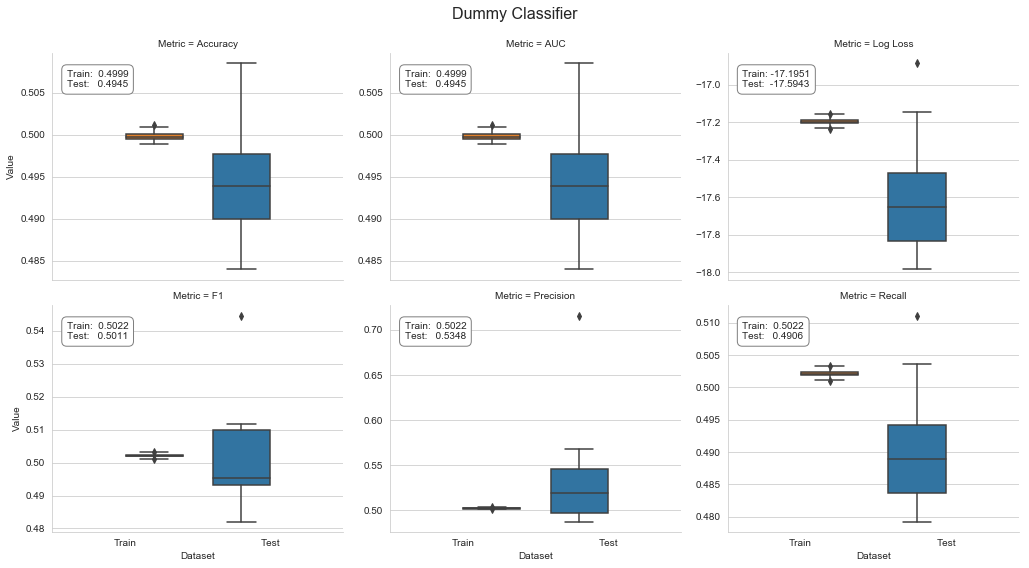

In [23]:
plot_result(dummy_result, model='Dummy Classifier')

## RandomForest

For comparison, we train a `RandomForestClassifier` as presented in [Chapter 10 on Decision Trees and Random Forests](../10_decision_trees_random_forests/02_random_forest.ipynb).

### Configure

In [24]:
rf_clf = RandomForestClassifier(n_estimators=200,             # will change from 10 to 100 in version 0.22 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto',
                                max_leaf_nodes=None, 
                                min_impurity_decrease=0.0, 
                                min_impurity_split=None, 
                                bootstrap=True, 
                                oob_score=True, 
                                n_jobs=-1,
                                random_state=42, 
                                verbose=1)

### Cross-validate

In [25]:
fname = 'results/rf_cv_result.joblib'
if not Path(fname).exists():
    rf_cv_result = run_cv(rf_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(rf_cv_result, fname)
else:
    rf_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 29.3min remaining:  5.9min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 29.4min finished


### Plot Results

In [26]:
rf_result = stack_results(rf_cv_result)
rf_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.659692,1.000000
Accuracy,0.616270,1.000000
F1,0.592029,1.000000
Log Loss,-0.611774,-0.169561
Precision,0.665563,1.000000
Recall,0.602865,1.000000


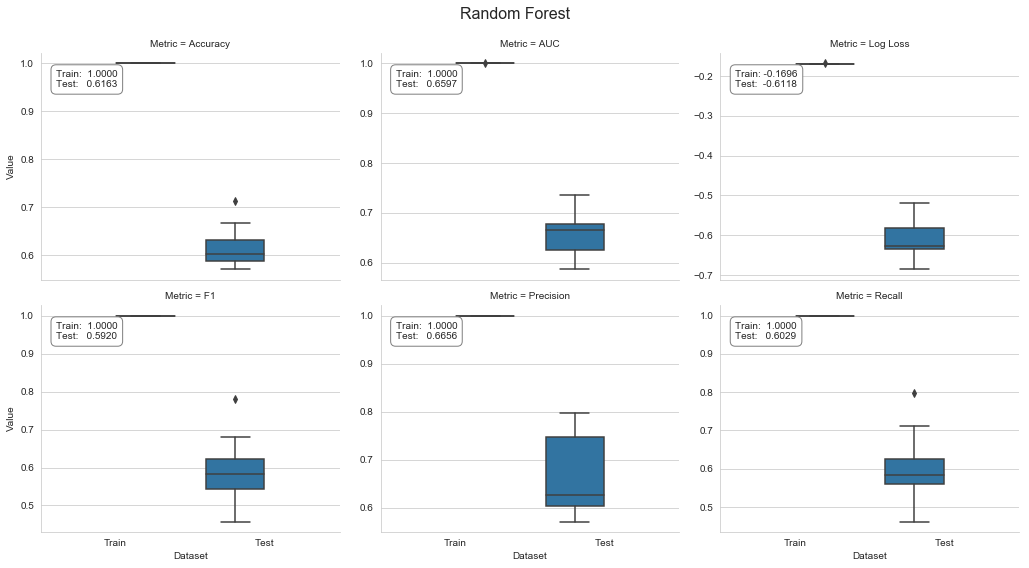

In [27]:
plot_result(rf_result, model='Random Forest')

## sklearn: AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. 

As demonstrated in the [previous chapter](../../10_decision_trees_random_forests), changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [28]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        min_impurity_split=None, 
                                        class_weight=None, 
                                        presort=False)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [29]:
ada_clf = AdaBoostClassifier(base_estimator=base_estimator,
                             n_estimators=200,
                             learning_rate=1.0,
                             algorithm='SAMME.R',
                             random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a custom 12-fold rolling time-series split to predict 1 month ahead for the last 12 months in the sample, using all available prior data for training, as shown in the following code:

In [30]:
fname = 'results/ada_cv_result.joblib'
if not Path(fname).exists():
    ada_cv_result = run_cv(ada_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(ada_cv_result, fname)
else:
    ada_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 16.0min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 16.1min finished


### Plot Result

In [31]:
ada_result = stack_results(ada_cv_result)
ada_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.668890,0.613425
Accuracy,0.626251,0.574614
F1,0.590490,0.574779
Log Loss,-0.692288,-0.692875
Precision,0.707423,0.585429
Recall,0.619776,0.587690


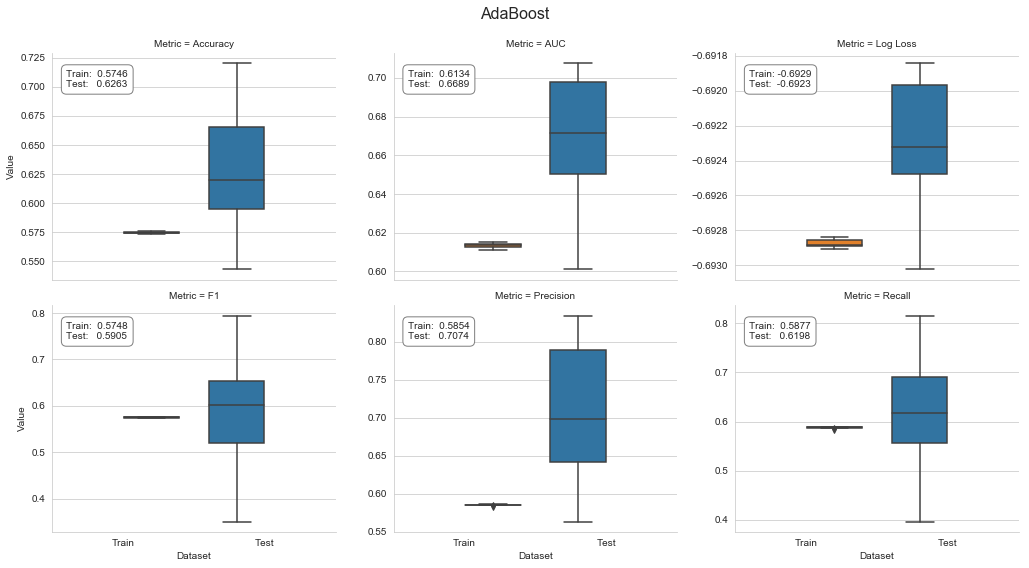

In [32]:
plot_result(ada_result, model='AdaBoost')

## GradientBoostingClassifier

The ensemble module of sklearn contains an implementation of gradient boosting trees for regression and classification, both binary and multiclass. 

### Configure

The following [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) initialization code illustrates the key tuning parameters that we previously introduced, in addition to those that we are familiar with from looking at standalone decision tree models.

The available loss functions include the exponential loss that leads to the AdaBoost algorithm and the deviance that corresponds to the logistic regression for probabilistic outputs. 

The `friedman_mse` node quality measure is a variation on the mean squared error that includes an improvement score (see GitHub references for links to original papers), as shown in the following code:

In [33]:
gb_clf = GradientBoostingClassifier(loss='deviance',                # deviance = logistic reg; exponential: AdaBoost
                                    learning_rate=0.1,              # shrinks the contribution of each tree
                                    n_estimators=100,               # number of boosting stages
                                    subsample=1.0,                  # fraction of samples used t fit base learners
                                    criterion='friedman_mse',       # measures the quality of a split
                                    min_samples_split=2,            
                                    min_samples_leaf=1, 
                                    min_weight_fraction_leaf=0.0,   # min. fraction of sum of weights
                                    max_depth=3,                    # opt value depends on interaction
                                    min_impurity_decrease=0.0, 
                                    min_impurity_split=None, 
                                    init=None, 
                                    random_state=None, 
                                    max_features=None, 
                                    verbose=0, 
                                    max_leaf_nodes=None, 
                                    warm_start=False, 
                                    presort='auto', 
                                    validation_fraction=0.1, 
                                    n_iter_no_change=None, 
                                    tol=0.0001)

### Cross-validate

In [34]:
fname = 'results/gb_cv_result.joblib'
if not Path(fname).exists():
    gb_cv_result = run_cv(gb_clf, y=y_clean, X=X_dummies_clean)
    joblib.dump(gb_cv_result, fname)
else:
    gb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed: 14.6min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 14.7min finished


### Plot Results

In [35]:
gb_result = stack_results(gb_cv_result)
gb_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.675116,0.694941
Accuracy,0.627907,0.629854
F1,0.589335,0.631810
Log Loss,-0.626003,-0.638505
Precision,0.714278,0.645043
Recall,0.625646,0.642046


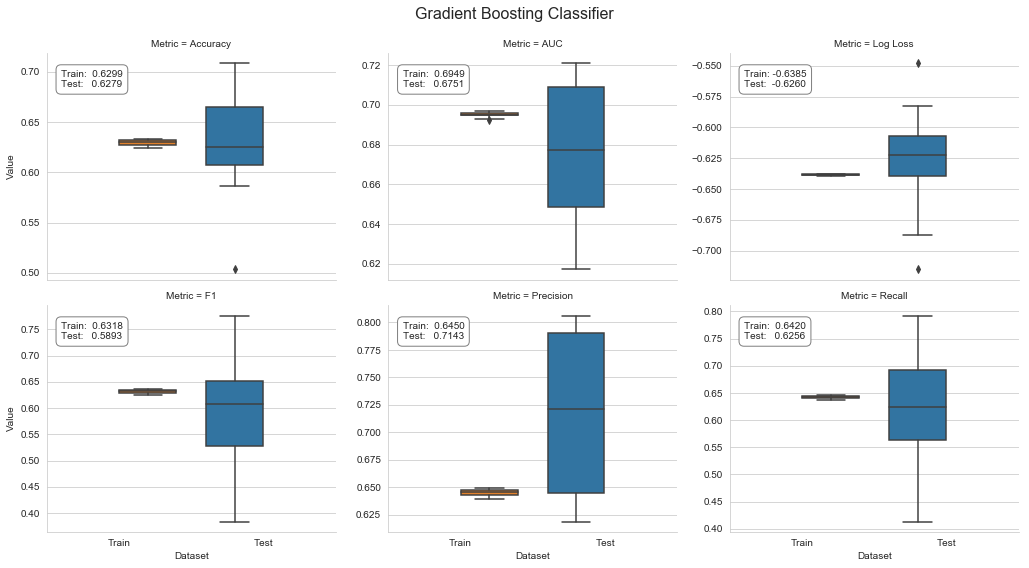

In [36]:
plot_result(gb_result, model='Gradient Boosting Classifier')

### Partial Dependence Plot

In [37]:
gb_clf.fit(y=y_clean, X=X_dummies_clean)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [38]:
# mean accuracy
gb_clf.score(X=X_dummies_clean, y=y_clean)

0.6398765972033428

In [39]:
y_score = gb_clf.predict_proba(X_dummies_clean)[:, 1]
roc_auc_score(y_score=y_score, y_true=y_clean)

0.6943822107527398

#### Feature Importance

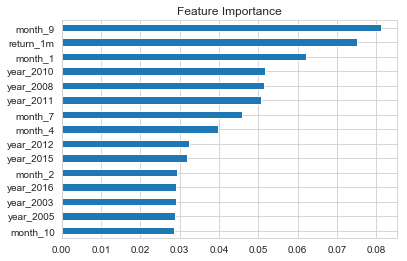

In [40]:
(pd.Series(gb_clf.feature_importances_, 
          index=X_dummies_clean.columns)
 .sort_values(ascending=False)
 .head(15)).sort_values().plot.barh(title='Feature Importance');

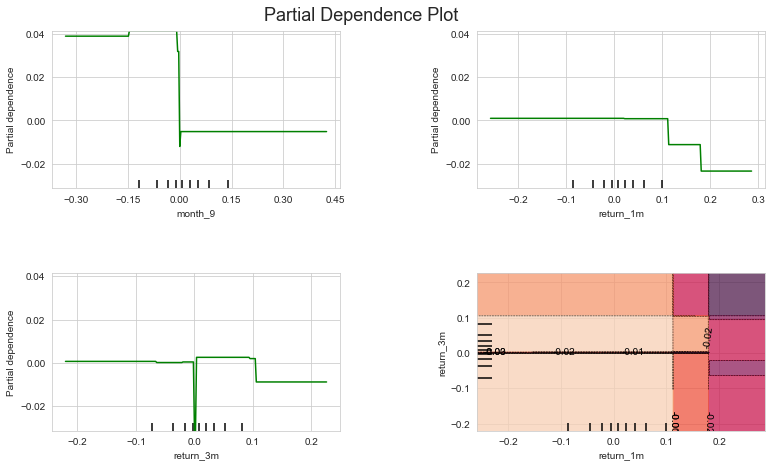

In [41]:
fig, axes = plot_partial_dependence(gbrt=gb_clf,
                                    X=X_dummies_clean,
                                    features=['month_9', 'return_1m', 'return_3m', ('return_1m', 'return_3m')],
                                    feature_names=['month_9','return_1m', 'return_3m'],
                                    percentiles=(0.01, 0.99),
                                    n_jobs=-1,
                                    n_cols=2,
                                    grid_resolution=250)
fig.suptitle('Partial Dependence Plot', fontsize=18)
fig.tight_layout()
fig.set_size_inches(12, 7)

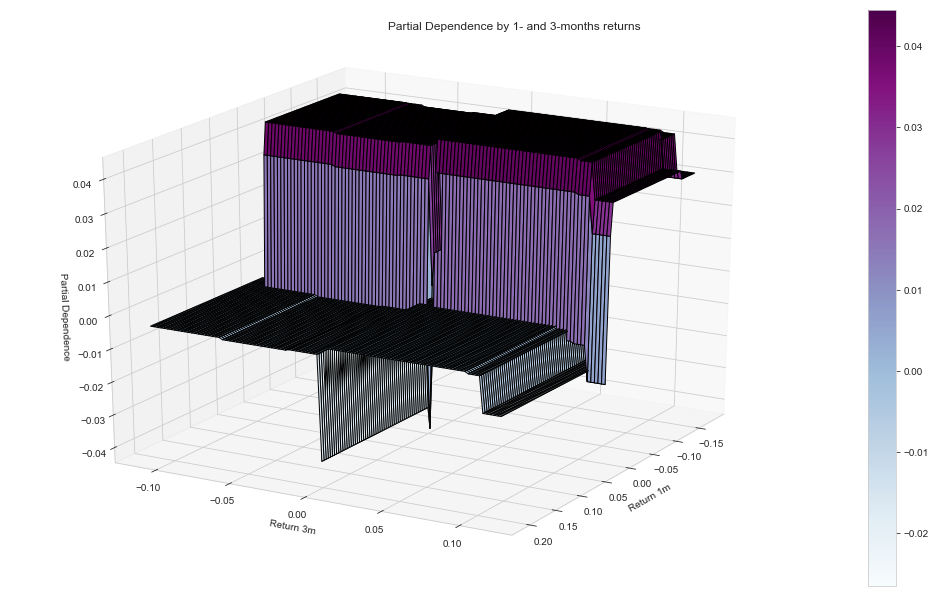

In [42]:
targets = ['return_1m', 'return_3m']
target_feature = [X_dummies_clean.columns.get_loc(t) for t in targets]
pdp, axes = partial_dependence(gb_clf,
                               target_feature,
                               X=X_dummies_clean,
                               grid_resolution=100)

XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].reshape(list(map(np.size, axes))).T

fig = plt.figure(figsize=(14, 8))
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z,
                       rstride=1,
                       cstride=1,
                       cmap=plt.cm.BuPu,
                       edgecolor='k')
ax.set_xlabel(' '.join(targets[0].split('_')).capitalize())
ax.set_ylabel(' '.join(targets[1].split('_')).capitalize())
ax.set_zlabel('Partial Dependence')
ax.view_init(elev=22, azim=30)

fig.colorbar(surf)
fig.suptitle('Partial Dependence by 1- and 3-months returns')
fig.tight_layout()
fig.savefig('partial_plot', dpi=300);

## XGBoost

### Configure

In [45]:
xgb_clf = XGBClassifier(max_depth=3,                  # Maximum tree depth for base learners.
                        learning_rate=0.1,            # Boosting learning rate (xgb's "eta")
                        n_estimators=100,             # Number of boosted trees to fit.
                        silent=True,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
#                         tree_method='gpu_hist',
                        n_jobs=-1,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [46]:
fname = 'results/xgb_cv_result.joblib'
if not Path(fname).exists():
    xgb_cv_result = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  7.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  7.2min finished


### Plot Results

In [47]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.690214,0.690331
Accuracy,0.626261,0.624804
F1,0.570426,0.624806
Log Loss,-0.590711,-0.638768
Precision,0.700872,0.640821
Recall,0.592593,0.636230


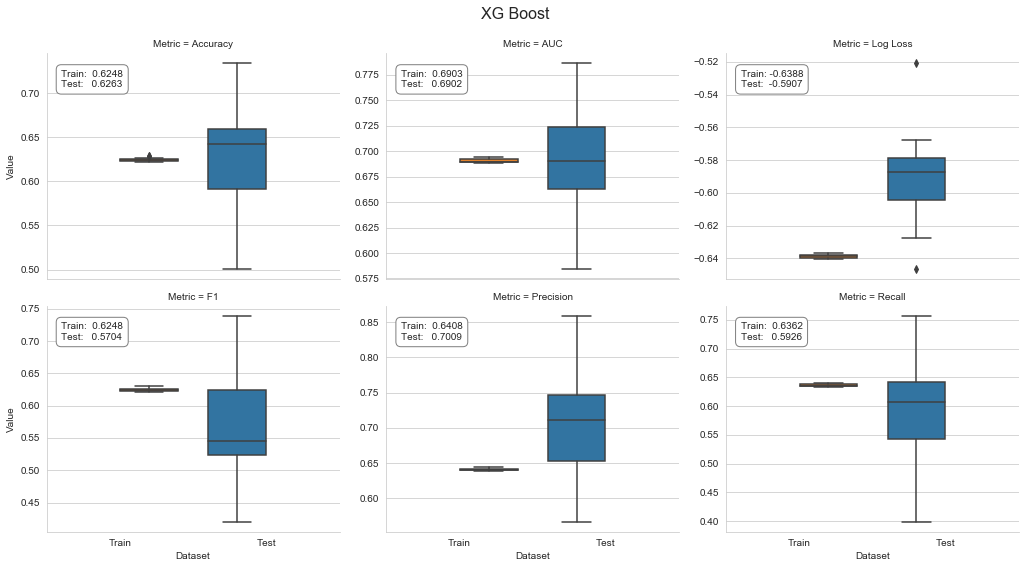

In [48]:
plot_result(xbg_result, model='XG Boost')

In [49]:
xgb_clf.fit(X=X_dummies, y=y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [50]:
fi = pd.Series(xgb_clf.feature_importances_, index=X_dummies.columns)

In [51]:
fi[fi>0].sort_values(ascending=False)

year_2017        0.075037
return_1m        0.056669
momentum_2       0.052265
year_2008        0.038251
year_2011        0.033383
momentum_3       0.032933
return_12m       0.032255
month_7          0.029952
year_2016        0.028686
month_5          0.027073
month_9          0.026135
month_6          0.025612
age_-1           0.025529
month_4          0.025016
year_2003        0.024576
year_2012        0.024119
year_2010        0.023824
year_2018        0.023558
year_2015        0.023194
year_2014        0.022717
month_1          0.022509
year_2013        0.022035
month_12         0.020363
return_1m_t-5    0.020260
month_10         0.018644
month_11         0.017674
year_2004        0.017612
year_2005        0.017531
month_2          0.016806
year_2007        0.016084
year_2009        0.016071
month_8          0.015683
year_2002        0.014997
return_1m_t-1    0.012754
momentum_9       0.011218
month_3          0.009692
return_3m        0.007578
msize_-1         0.007515
return_1m_t-

## LightGBM

### Configure

In [52]:
lgb_clf = LGBMClassifier(boosting_type='gbdt',
#                          device='gpu',
                         objective='binary',          # learning task
                         metric='auc',
                         num_leaves=31,               # Maximum tree leaves for base learners.
                         max_depth=-1,                # Maximum tree depth for base learners, -1 means no limit.
                         learning_rate=0.1,          # Adaptive lr via callback override in .fit() method  
                         n_estimators=100,            # Number of boosted trees to fit
                         subsample_for_bin=200000,    # Number of samples for constructing bins.
                         class_weight=None,           # dict, 'balanced' or None
                         min_split_gain=0.0,          # Minimum loss reduction for further split
                         min_child_weight=0.001,      # Minimum sum of instance weight(hessian)
                         min_child_samples=20,        # Minimum number of data need in a child(leaf)
                         subsample=1.0,               # Subsample ratio of training samples
                         subsample_freq=0,            # Frequency of subsampling, <=0: disabled
                         colsample_bytree=1.0,        # Subsampling ratio of features
                         reg_alpha=0.0,               # L1 regularization term on weights
                         reg_lambda=0.0,              # L2 regularization term on weights
                         random_state=42,             # Random number seed; default: C++ seed
                         n_jobs=-1,                   # Number of parallel threads.
                         silent=False,
                         importance_type='gain',      # default: 'split' or 'gain'
#                          feature_fraction=1,
                        )

### Cross-Validate

#### Using categorical features

In [53]:
fname = 'results/lgb_factor_cv_result.joblib'
if not Path(fname).exists():
    lgb_factor_cv_result = run_cv(lgb_clf, X=X_factors, fit_params={'categorical_feature': cat_cols})
    joblib.dump(lgb_factor_cv_result, fname)
else:
    lgb_factor_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.3min remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.3min finished


##### Plot Results

In [54]:
lgb_factor_result = stack_results(lgb_factor_cv_result)
lgb_factor_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.685903,0.753829
Accuracy,0.591003,0.682658
F1,0.530207,0.685766
Log Loss,-0.603009,-0.587044
Precision,0.608764,0.692368
Recall,0.578861,0.690098


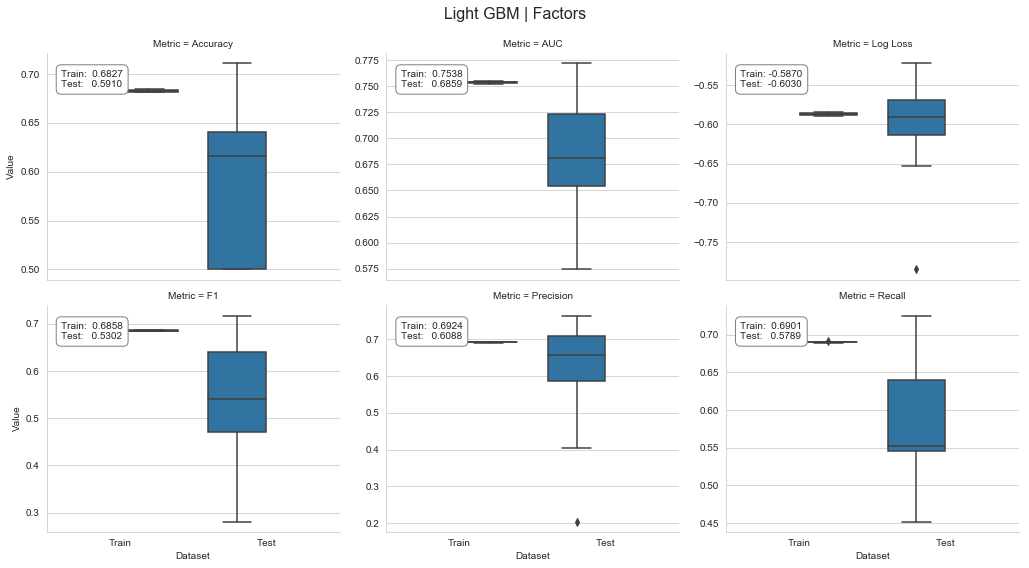

In [55]:
plot_result(lgb_factor_result, model='Light GBM | Factors')

#### Using dummy variables

In [56]:
fname = 'results/lgb_dummy_cv_result.joblib'
if not Path(fname).exists():
    lgb_dummy_cv_result = run_cv(lgb_clf)
    joblib.dump(lgb_dummy_cv_result, fname)
else:
    lgb_dummy_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  1.1min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.1min finished


##### Plot results

In [57]:
lgb_dummy_result = stack_results(lgb_dummy_cv_result)
lgb_dummy_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.690086,0.747246
Accuracy,0.624242,0.675954
F1,0.570777,0.678493
Log Loss,-0.581760,-0.594757
Precision,0.655675,0.690174
Recall,0.599825,0.685142


## Catboost

### Configure

In [61]:
cat_clf = CatBoostClassifier(iterations=500, 
                             learning_rate=0.03, 
                             depth=6, 
                             l2_leaf_reg=3, 
                             model_size_reg=None, 
                             rsm=None,                             # Subsample ratio of columns
                             loss_function='Logloss', 
                             border_count=32,                      # number of partitions for Num feature
                             feature_border_type='MinEntropy',     # Type of binarization target (for regression)
#                              fold_permutation_block_size=1,        # To accelerate the learning
                             od_pval=None,                         # overfitting detector to stop training
                             od_wait=None,                         # No iterations od will wait
                             od_type=None,                         # Type of overfitting detector
                             nan_mode='Min',                       # treat missing values as min [max, forbidden]
                             counter_calc_method=None,             # 
                             leaf_estimation_iterations=1, 
                             leaf_estimation_method='Gradient', 
                             thread_count=None,                    # None: no of cores
                             random_seed=None,              
                             use_best_model=None, 
                             best_model_min_trees=None, 
#                              verbose=100, 
#                              logging_level='Verbose',  
                             metric_period=1, 
                             simple_ctr=None,                      # Binarization settings for categorical features
                             ctr_leaf_count_limit=None, 
                             store_all_simple_ctr=None, 
                             max_ctr_complexity=1, 
                             has_time=None, 
                             allow_const_label=None, 
                             classes_count=None, 
                             class_weights=None, 
                             one_hot_max_size=None,                # Convert the feature to float
                             random_strength=None, 
                             name=None, 
                             ignored_features=None, 
                             train_dir=None, 
                             custom_loss=None, 
                             custom_metric=None,
                             eval_metric='AUC', 
                             bagging_temperature=None, 
                             save_snapshot=None, 
                             snapshot_file=None, 
                             snapshot_interval=None, 
                             fold_len_multiplier=None, 
                             used_ram_limit=None, 
                             gpu_ram_part=.2, 
                             pinned_memory_size=None, 
                             allow_writing_files=None, 
                             final_ctr_computation_mode=None, 
                             approx_on_full_history=None, 
                             boosting_type=None, 
                             combinations_ctr=None, 
                             per_feature_ctr=None, 
                             ctr_description=None, 
#                              task_type='GPU', 
                             bootstrap_type='Bayesian', 
                             subsample=None, 
                             dev_score_calc_obj_block_size=None, 
                             gpu_cat_features_storage=None, 
                             data_partition=None, 
                             metadata=None, 
                             early_stopping_rounds=None,
                             cat_features=None)

### Cross-Validate

In [62]:
s = pd.Series(X_factors.columns.tolist())
cat_cols_idx = s[s.isin(cat_cols)].index.tolist()

In [63]:
fname = 'results/cat_cv_result.joblib'
if not Path(fname).exists():
    cat_cv_result = run_cv(cat_clf, X=X_factors, fit_params={'cat_features': cat_cols_idx})
    joblib.dump(cat_cv_result, fname)
else:
    cat_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:  8.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  8.1min finished


### Plot Results

In [64]:
cat_result = stack_results(cat_cv_result)
cat_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()

Dataset,Test,Train
Metric,,
AUC,0.697064,0.632887
Accuracy,0.595647,0.583538
F1,0.525387,0.580220
Log Loss,-0.610451,-0.660919
Precision,0.618131,0.598573
Recall,0.580783,0.596744


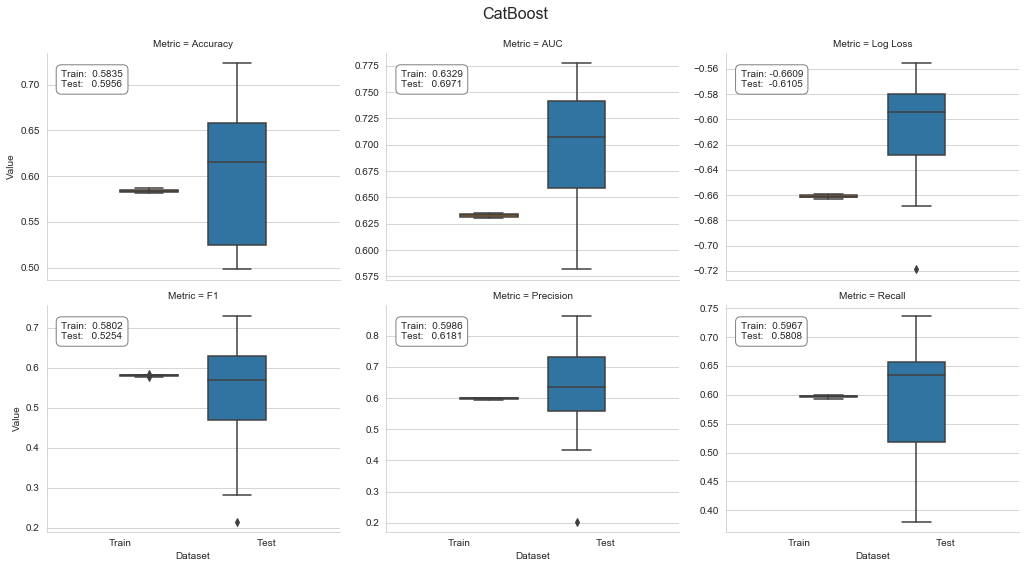

In [65]:
plot_result(cat_result, model='CatBoost')

## Compare Results

In [66]:
results = {'Baseline': dummy_result,
           'Random Forest': rf_result,
           'AdaBoost': ada_result,
           'Gradient Booster': gb_result,
           'XG Boost': xbg_result,
           'LightGBM Dummies': lgb_dummy_result,
           'LightGBM Factors': lgb_factor_result,
           'CatBoost': cat_result}
df = pd.DataFrame()
for model, result in results.items():
    df = pd.concat([df, result.groupby(['Metric', 'Dataset']
                                       ).Value.mean().unstack()['Test'].to_frame(model)], axis=1)

df.T.sort_values('AUC', ascending=False)

Metric,AUC,Accuracy,F1,Log Loss,Precision,Recall
CatBoost,0.697064,0.595647,0.525387,-0.610451,0.618131,0.580783
XG Boost,0.690214,0.626261,0.570426,-0.590711,0.700872,0.592593
LightGBM Dummies,0.690086,0.624242,0.570777,-0.581760,0.655675,0.599825
LightGBM Factors,0.685903,0.591003,0.530207,-0.603009,0.608764,0.578861
Gradient Booster,0.675116,0.627907,0.589335,-0.626003,0.714278,0.625646
AdaBoost,0.668890,0.626251,0.590490,-0.692288,0.707423,0.619776
Random Forest,0.659692,0.616270,0.592029,-0.611774,0.665563,0.602865
Baseline,0.494516,0.494516,0.501068,-17.594264,0.534767,0.490601


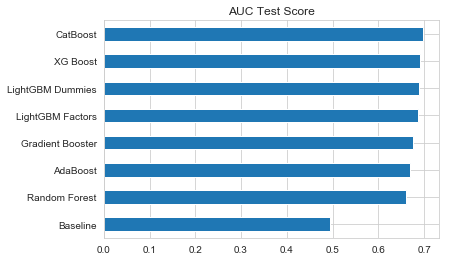

In [67]:
df.T['AUC'].sort_values().plot.barh(title='AUC Test Score');

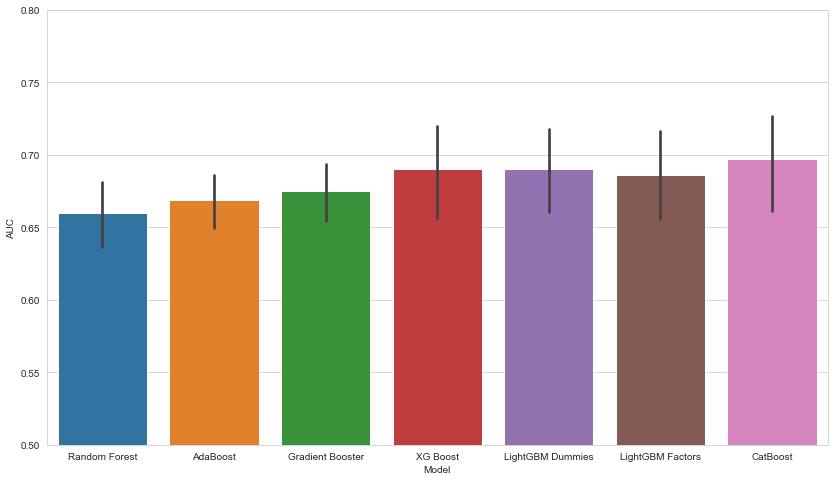

In [68]:
fig, ax = plt.subplots(figsize=(14, 8))
auc = pd.concat([v.loc[(v.Dataset=='Test') & (v.Metric=='AUC'), 'Value'].to_frame('AUC').assign(Model=k) 
                 for k, v in results.items()])
auc = auc[auc.Model != 'Baseline']
sns.barplot(x='Model', y='AUC', data=auc, ax=ax)
ax.set_ylim(.5, .8);